In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import zipfile
import os

# Define paths
new_zip_path = '/content/gdrive/MyDrive/PPNCKH(Pho_Cam)/Cam7.zip'
new_extract_path = 'cam_extracted'

# Extract the zip file
with zipfile.ZipFile(new_zip_path, 'r') as zip_ref:
    zip_ref.extractall(new_extract_path)

# List the contents of the extracted directory
os.listdir(new_extract_path)

['Cam7']

*Tạo* **folder** chia độ ngọt, phân bố các phổ theo độ ngọt đã chia (chỉ chạy lần đầu)

In [ ]:
import os
import re
import random
import shutil
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter


# Hàm làm mượt phổ sử dụng Savitzky-Golay
def smooth_spectrum(spectrum, window_length=51, polyorder=3):
    if len(spectrum) < window_length:
        # Điều chỉnh window_length sao cho là số lẻ
        window_length = len(spectrum) if len(spectrum) % 2 == 1 else len(spectrum) - 1
    return savgol_filter(spectrum, window_length=window_length, polyorder=polyorder)

def create_brix_folders(root_folder):
    """Tạo các thư mục min_to_6, 6_to_9, 9_to_max trong thư mục gốc"""
    brix_folders = ['min_to_5', '5_to_9', '9_to_max']
    for folder in brix_folders:
        folder_path = os.path.join(root_folder, folder)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

def move_file_based_on_brix(file_path, label, root_folder):
    """Di chuyển tệp vào thư mục tương ứng dựa trên độ ngọt Brix"""
    if label < 5:
        target_folder = os.path.join(root_folder, 'min_to_5')
    elif 5 <= label < 9:
        target_folder = os.path.join(root_folder, '5_to_9')
    else:
        target_folder = os.path.join(root_folder, '9_to_max')

    shutil.move(file_path, os.path.join(target_folder, os.path.basename(file_path)))

def move(data_dir):
    for category in os.listdir(data_dir):  # Loop over categories A, B, C, D
        category_path = os.path.join(data_dir, category)
        if not os.path.isdir(category_path):
            continue

        for fruit in os.listdir(category_path):  # Loop over fruit folders (e.g., A00, A01,...)
            fruit_path = os.path.join(category_path, fruit)
            if not os.path.isdir(fruit_path):
                continue

            spectra_list = []
            labels = []

            for file in os.listdir(fruit_path):  # Loop over spectral .txt files
                if not file.endswith(".txt"):
                    continue

                try:
                    match = re.search(r"\{([\d.]+)\}", file)
                    if match:
                        label = float(match.group(1))
                    else:
                        continue
                    file_path = os.path.join(fruit_path, file)
                    labels.append(label)

                    # Di chuyển file vào thư mục phù hợp dựa trên Brix
                    move_file_based_on_brix(file_path, label, data_dir)

                except Exception as e:
                    print(f"Error processing {file}: {e}")
                    continue

# Create folders for Brix categories
root_folder = r"/content/cam_extracted/Cam7"
create_brix_folders(root_folder)
move(root_folder)

**Data cũ**

In [ ]:
from scipy.signal import savgol_filter
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

def smooth_spectrum(spectrum, window_length=51, polyorder=3):
    if len(spectrum) < window_length:
        # Điều chỉnh window_length sao cho là số lẻ
        window_length = len(spectrum) if len(spectrum) % 2 == 1 else len(spectrum) - 1
    return savgol_filter(spectrum, window_length=window_length, polyorder=polyorder)

def load_and_split_spectra(data_dir, boost_factor=5):



  """Load spectral data, manually split into train/test sets per fruit, shuffle them, and return X_train, X_test, y_train, y_test, with statistics."""
  X_train, X_test, y_train, y_test = [], [], [], []
  stats = {}

  for category in os.listdir(data_dir):  # Loop over categories A, B, C, D
      category_path = os.path.join(data_dir, category)
      if not os.path.isdir(category_path):
          continue

      for fruit in os.listdir(category_path):  # Loop over fruit folders (e.g., A00, A01,...)
          fruit_path = os.path.join(category_path, fruit)
          if not os.path.isdir(fruit_path):
              continue

          spectra_list = []
          labels = []

          for file in os.listdir(fruit_path):  # Loop over spectral .txt files
              if not file.endswith(".txt"):
                  continue

              try:
                  match = re.search(r"\{([\d.]+)\}", file)
                  if match:
                      label = float(match.group(1))
                  else:
                      continue

                  file_path = os.path.join(fruit_path, file)
                  with open(file_path, 'r') as f:
                      lines = f.readlines()

                  start_index = None
                  for i, line in enumerate(lines):
                      if ">>>>>Begin Spectral Data<<<<<" in line:
                          start_index = i + 2
                          break
                  if start_index is None:
                      continue

                  spectral_data = [line.strip().split() for line in lines[start_index:] if line.strip()]
                  df = pd.DataFrame(spectral_data, columns=["wavelength", "intensity"], dtype=float)
                  norm_intensity = df["intensity"].values / np.max(df["intensity"].values)
                  norm_intensity = smooth_spectrum(norm_intensity, window_length=51, polyorder=3)
                  spectra_list.append(norm_intensity)
                  labels.append(label)
              except Exception as e:
                  print(f"Error processing {file}: {e}")
                  continue

          # Split per fruit
          if spectra_list:
              combined = list(zip(spectra_list, labels))
              random.shuffle(combined)
              split_idx = int(len(combined) * 0.8)
              train_data, test_data = combined[:split_idx], combined[split_idx:]

              X_train.extend([x for x, _ in train_data])
              y_train.extend([y for _, y in train_data])
              X_test.extend([x for x, _ in test_data])
              y_test.extend([y for _, y in test_data])

              stats[fruit] = {
                  "total": len(combined),
                  "train": len(train_data),
                  "test": len(test_data)
              }

  # Shuffle final train and test sets
  train_combined = list(zip(X_train, y_train))
  test_combined = list(zip(X_test, y_test))
  random.shuffle(train_combined)
  random.shuffle(test_combined)
  X_train, y_train = zip(*train_combined)
  X_test, y_test = zip(*test_combined)

  # Convert to numpy arrays and reshape for LSTM
  X_train, X_test, y_train, y_test = map(np.array, [X_train, X_test, y_train, y_test])
  X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
  X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

  X_train_2d = X_train.reshape((X_train.shape[0], X_train.shape[1]))
  X_test_2d = X_test.reshape((X_test.shape[0], X_test.shape[1]))

  # Display statistics
  stats_df = pd.DataFrame.from_dict(stats, orient='index')
  print(stats_df)

  return X_train, X_test, y_train, y_test, stats_df, X_train_2d, X_test_2d

**Data mới**

In [ ]:
from scipy.signal import savgol_filter
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

def smooth_spectrum(spectrum, window_length=51, polyorder=3):
    if len(spectrum) < window_length:
        # Điều chỉnh window_length sao cho là số lẻ
        window_length = len(spectrum) if len(spectrum) % 2 == 1 else len(spectrum) - 1
    return savgol_filter(spectrum, window_length=window_length, polyorder=polyorder)

def load_and_split_spectra(data_dir, boost_factor=5):
    """Load spectral data, manually split into train/test sets per fruit, shuffle them, and return X_train, X_test, y_train, y_test, with statistics."""
    X_train, X_test, y_train, y_test = [], [], [], []
    stats = {}

    # for category in os.listdir(data_dir):  # Loop over categories A, B, C, D
    #     category_path = os.path.join(data_dir, category)
    #     if not os.path.isdir(category_path):
    #         continue

    for fruit in os.listdir(data_dir):  # Loop over fruit folders (e.g., A00, A01,...)
        fruit_path = os.path.join(data_dir, fruit)
        if not os.path.isdir(fruit_path):
            continue

        spectra_list = []
        labels = []

        for file in os.listdir(fruit_path):  # Loop over spectral .txt files
            if not file.endswith(".txt"):
                continue

            try:
                match = re.search(r"\{([\d.]+)\}", file)
                if match:
                    label = float(match.group(1))
                else:
                    continue

                file_path = os.path.join(fruit_path, file)
                with open(file_path, 'r') as f:
                    lines = f.readlines()

                start_index = None
                for i, line in enumerate(lines):
                    if ">>>>>Begin Spectral Data<<<<<" in line:
                        start_index = i + 2
                        break
                if start_index is None:
                    continue

                spectral_data = [line.strip().split() for line in lines[start_index:] if line.strip()]
                df = pd.DataFrame(spectral_data, columns=["wavelength", "intensity"], dtype=float)
                norm_intensity = df["intensity"].values / np.max(df["intensity"].values)
                norm_intensity = smooth_spectrum(norm_intensity, window_length=51, polyorder=3)
                spectra_list.append(norm_intensity)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {file}: {e}")
                continue

        # Split per fruit
        if spectra_list:
            combined = list(zip(spectra_list, labels))
            random.shuffle(combined)
            split_idx = int(len(combined) * 0.8)
            train_data, test_data = combined[:split_idx], combined[split_idx:]

            X_train.extend([x for x, _ in train_data])
            y_train.extend([y for _, y in train_data])
            X_test.extend([x for x, _ in test_data])
            y_test.extend([y for _, y in test_data])

            stats[fruit] = {
                "total": len(combined),
                "train": len(train_data),
                "test": len(test_data)
            }

    # Shuffle final train and test sets
    train_combined = list(zip(X_train, y_train))
    test_combined = list(zip(X_test, y_test))
    random.shuffle(train_combined)
    random.shuffle(test_combined)
    X_train, y_train = zip(*train_combined)
    X_test, y_test = zip(*test_combined)

    # Convert to numpy arrays and reshape for LSTM
    X_train, X_test, y_train, y_test = map(np.array, [X_train, X_test, y_train, y_test])
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    X_train_2d = X_train.reshape((X_train.shape[0], X_train.shape[1]))
    X_test_2d = X_test.reshape((X_test.shape[0], X_test.shape[1]))

    # Display statistics
    stats_df = pd.DataFrame.from_dict(stats, orient='index')
    print(stats_df)

    return X_train, X_test, y_train, y_test, stats_df, X_train_2d, X_test_2d

In [ ]:
# Load data
X_train, X_test, y_train, y_test, stats_df, X_train_2d, X_test_2d = load_and_split_spectra("/content/cam_extracted/Cam7")
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_train)

     total  train  test
A40     11      8     3
A29     11      8     3
A17     12      9     3
A20     12      9     3
A47     11      8     3
..     ...    ...   ...
B18     22     17     5
B11     17     13     4
B24     13     10     3
B21     15     12     3
B14     14     11     3

[130 rows x 3 columns]
(1275, 2047, 1)
(408, 2047, 1)
(1275,)
[ 7.5  4.6  8.3 ...  8.6  6.6 11.3]


In [ ]:
def categorize_sweetness(label):

    if 0 <= label < 5:
        return 0  # Loại 1
    elif 5 <= label < 10:
        return 1  # Loại 2
    else:
        return 2  # Loại 3



##SVM

=== Đánh giá mô hình SVM với tham số mặc định ===
Độ chính xác: 0.8799

=== Thông tin thời gian ===
Thời gian huấn luyện: 7.4060 giây
Thời gian dự đoán: 0.9716 giây
Tổng thời gian thực thi: 8.4192 giây

=== Đánh giá toàn mô hình ===
Macro average:
  Precision: 0.7763
  Recall: 0.7729
  F1-score: 0.7744

Micro average:
  Precision: 0.8799
  Recall: 0.8799
  F1-score: 0.8799

Weighted average:
  Precision: 0.8803
  Recall: 0.8799
  F1-score: 0.8800

Log Loss: 0.3587
ROC-AUC (One-vs-Rest): 0.9224
ROC-AUC (One-vs-One): 0.9224

Báo cáo phân loại:
                  precision    recall  f1-score   support

Loại 1 (3.3-4.9)       0.63      0.60      0.62        20
  Loại 2 (5-9.9)       0.93      0.92      0.92       304
Loại 3 (10-13.3)       0.77      0.80      0.78        84

        accuracy                           0.88       408
       macro avg       0.78      0.77      0.77       408
    weighted avg       0.88      0.88      0.88       408



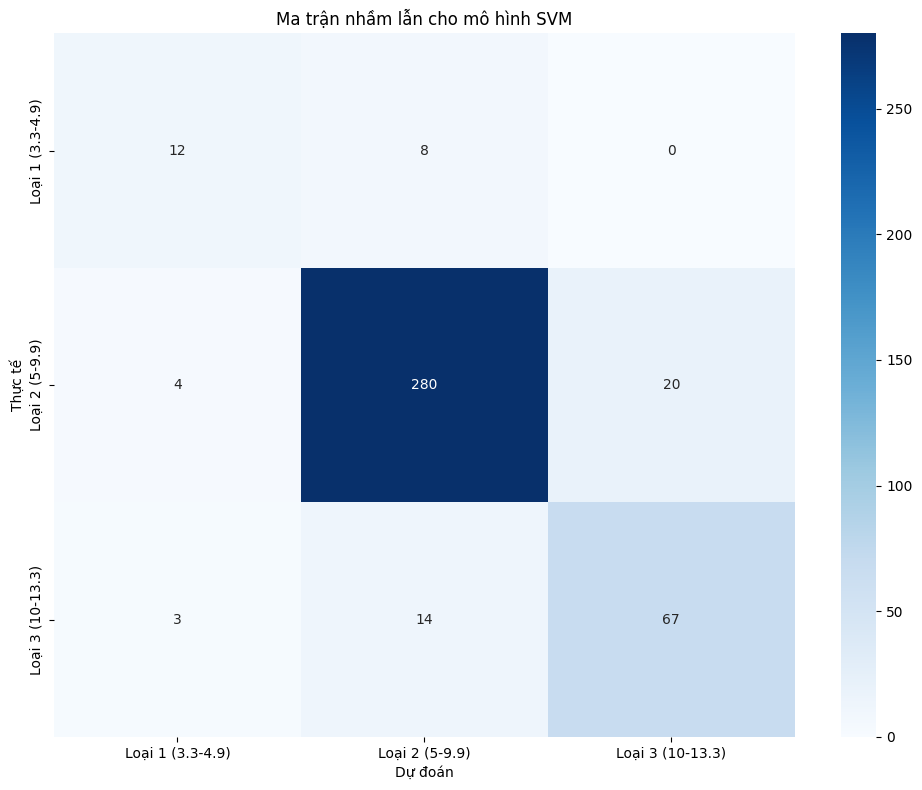

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                            precision_score, recall_score, f1_score,
                            roc_auc_score, log_loss)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import time

def build_and_evaluate_svm_model(X_train_2d, X_test_2d, y_train, y_test):
    """
    Xây dựng và đánh giá mô hình SVM cho bài toán phân loại độ ngọt
    """
    start_time = time.time()
    # Chuyển đổi nhãn thành 3 loại như yêu cầu
    y_train_cat = np.array([categorize_sweetness(y) for y in y_train])
    y_test_cat = np.array([categorize_sweetness(y) for y in y_test])
    # print(y_train)
    # print(y_test)
    # print(y_train_cat)
    # print(y_test_cat)
    # Tạo pipeline với chuẩn hóa dữ liệu và mô hình SVM
    svm_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', C=140, gamma=0.001, probability=True))
    ])

    train_start_time = time.time()
    # Huấn luyện mô hình
    svm_pipeline.fit(X_train_2d, y_train_cat)
    train_time = time.time() - train_start_time
    predict_start_time = time.time()
    # Dự đoán
    y_pred = svm_pipeline.predict(X_test_2d)

    # Dự đoán xác suất cho Log Loss và ROC-AUC
    y_pred_proba = svm_pipeline.predict_proba(X_test_2d)
    predict_time = time.time() - predict_start_time
    # Đánh giá mô hình
    accuracy = accuracy_score(y_test_cat, y_pred)
    class_names = ['Loại 1 (3.3-4.9)', 'Loại 2 (5-9.9)', 'Loại 3 (10-13.3)']

    print(f"Độ chính xác: {accuracy:.4f}")

    # Tính precision, recall, f1-score cho toàn mô hình (macro, micro, weighted)
    precision_macro = precision_score(y_test_cat, y_pred, average='macro')
    recall_macro = recall_score(y_test_cat, y_pred, average='macro')
    f1_macro = f1_score(y_test_cat, y_pred, average='macro')

    precision_micro = precision_score(y_test_cat, y_pred, average='micro')
    recall_micro = recall_score(y_test_cat, y_pred, average='micro')
    f1_micro = f1_score(y_test_cat, y_pred, average='micro')

    precision_weighted = precision_score(y_test_cat, y_pred, average='weighted')
    recall_weighted = recall_score(y_test_cat, y_pred, average='weighted')
    f1_weighted = f1_score(y_test_cat, y_pred, average='weighted')

    logloss = log_loss(y_test_cat, y_pred_proba)

    # Tính AUC-ROC cho bài toán đa lớp
    # Chuyển y_test_cat thành dạng one-hot

    n_classes = len(np.unique(y_test_cat))
    y_test_bin = label_binarize(y_test_cat, classes=range(n_classes))

    # Tính ROC-AUC score
    roc_auc_ovr = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr', average='macro')
    roc_auc_ovo = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovo', average='macro')

    total_time = time.time() - start_time

    print("\n=== Thông tin thời gian ===")
    print(f"Thời gian huấn luyện: {train_time:.4f} giây")
    print(f"Thời gian dự đoán: {predict_time:.4f} giây")
    print(f"Tổng thời gian thực thi: {total_time:.4f} giây")

    print("\n=== Đánh giá toàn mô hình ===")
    print(f"Macro average:")
    print(f"  Precision: {precision_macro:.4f}")
    print(f"  Recall: {recall_macro:.4f}")
    print(f"  F1-score: {f1_macro:.4f}")

    print(f"\nMicro average:")
    print(f"  Precision: {precision_micro:.4f}")
    print(f"  Recall: {recall_micro:.4f}")
    print(f"  F1-score: {f1_micro:.4f}")

    print(f"\nWeighted average:")
    print(f"  Precision: {precision_weighted:.4f}")
    print(f"  Recall: {recall_weighted:.4f}")
    print(f"  F1-score: {f1_weighted:.4f}")

    print(f"\nLog Loss: {logloss:.4f}")
    print(f"ROC-AUC (One-vs-Rest): {roc_auc_ovr:.4f}")
    print(f"ROC-AUC (One-vs-One): {roc_auc_ovo:.4f}")

    print("\nBáo cáo phân loại:")
    print(classification_report(y_test_cat, y_pred, target_names=class_names))

    # Vẽ ma trận nhầm lẫn
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test_cat, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.title('Ma trận nhầm lẫn cho mô hình SVM')
    plt.tight_layout()
    plt.show()

    return svm_pipeline

def hyperparameter_tuning(X_train_2d, y_train):
    """
    Tối ưu hóa hyperparameter cho mô hình SVM
    """
    from sklearn.model_selection import GridSearchCV

    # Chuyển đổi nhãn thành 3 loại
    y_train_cat = np.array([categorize_sweetness(y) for y in y_train])

    # Định nghĩa pipeline
    svm_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(probability=True))
    ])

    # Định nghĩa không gian tìm kiếm
    param_grid = {
        'svm__C': [0.1, 1, 10, 100],
        'svm__gamma': ['scale', 'auto', 0.1, 0.01],
        'svm__kernel': ['rbf', 'poly', 'sigmoid']
    }

    # Thực hiện tìm kiếm lưới với cross-validation
    grid_search = GridSearchCV(
        svm_pipeline,
        param_grid,
        cv=5,
        scoring='accuracy',
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(X_train_2d, y_train_cat)

    # In kết quả
    print(f"Tham số tốt nhất: {grid_search.best_params_}")
    print(f"Độ chính xác tốt nhất: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_

def main(X_train_2d, X_test_2d, y_train, y_test):
    # Xây dựng và đánh giá mô hình SVM cơ bản
    print("=== Đánh giá mô hình SVM với tham số mặc định ===")
    svm_model = build_and_evaluate_svm_model(X_train_2d, X_test_2d, y_train, y_test)


best_model = main(X_train_2d, X_test_2d, y_train, y_test)

**XGboost**

Bắt đầu chạy chương trình lúc: 04:05:23

XGBOOST MODEL

=== Thời gian xây dựng mô hình XGBoost ===
Thời gian tiền xử lý: 0.0011 giây
Thời gian huấn luyện: 95.2281 giây
Tổng thời gian: 95.2292 giây

=== Đánh giá mô hình XGBoost ===
Độ chính xác: 0.8431

=== Đánh giá toàn mô hình ===
Macro average:
  Precision: 0.7685
  Recall: 0.5917
  F1-score: 0.6349

Micro average:
  Precision: 0.8431
  Recall: 0.8431
  F1-score: 0.8431

Weighted average:
  Precision: 0.8334
  Recall: 0.8431
  F1-score: 0.8290

Log Loss: 0.4185
ROC-AUC (One-vs-Rest): 0.9006
ROC-AUC (One-vs-One): 0.9006

Báo cáo phân loại:
                  precision    recall  f1-score   support

Loại 1 (3.3-4.9)       0.67      0.20      0.31        20
  Loại 2 (5-9.9)       0.86      0.94      0.90       304
Loại 3 (10-13.3)       0.78      0.63      0.70        84

        accuracy                           0.84       408
       macro avg       0.77      0.59      0.63       408
    weighted avg       0.83      0.84      0.83     

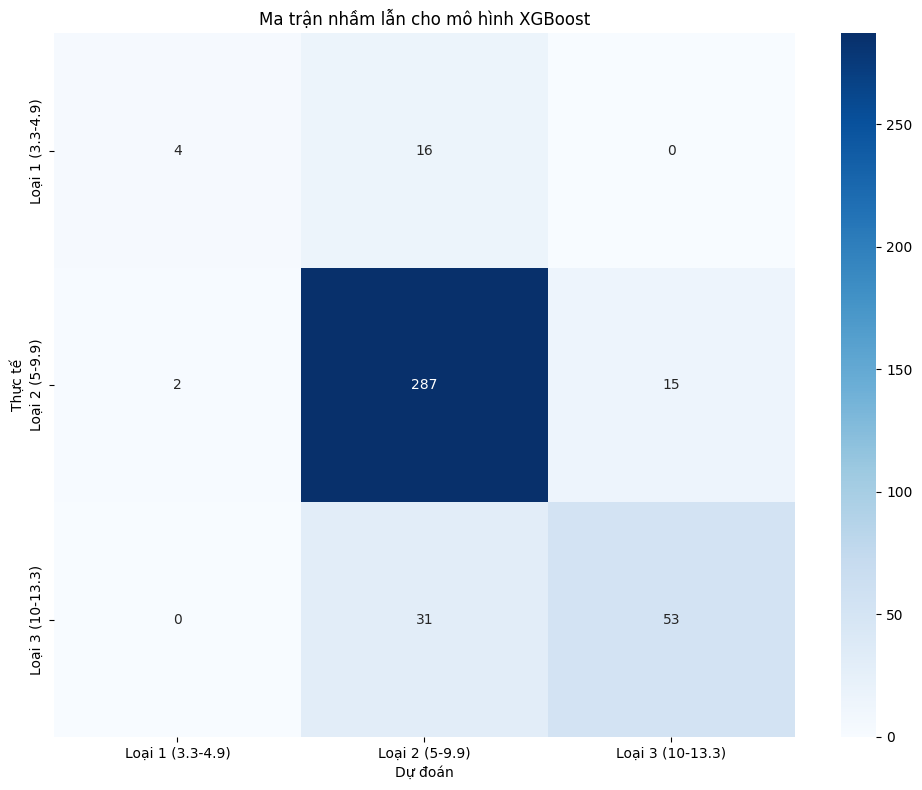


=== Tổng thời gian thực thi XGBoost ===
Thời gian: 95.5452 giây

=== So sánh các mô hình ===


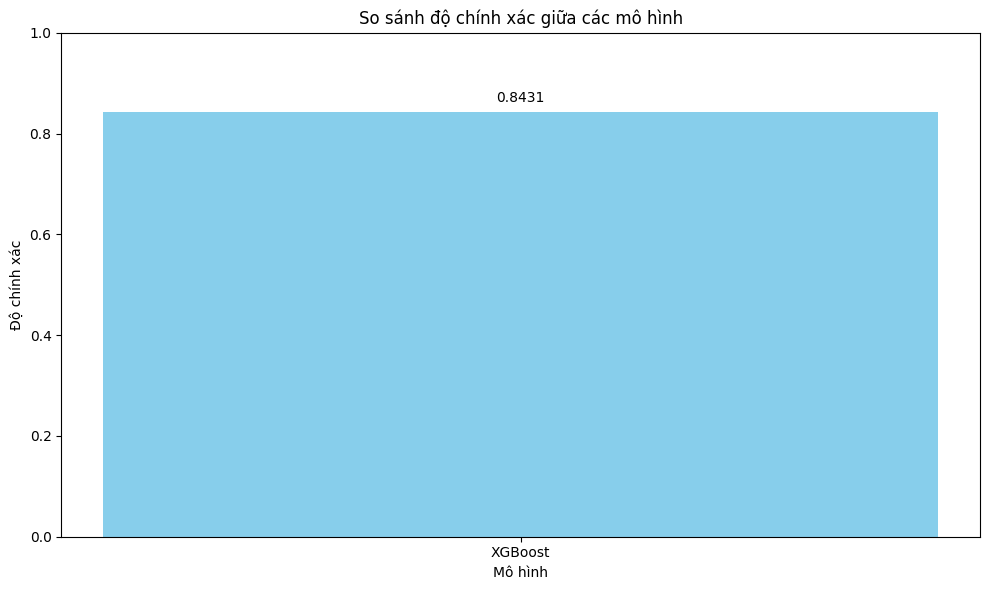


=== Thời gian so sánh mô hình ===
Tổng thời gian: 0.1477 giây

TỔNG KẾT THỜI GIAN THỰC THI
Thời gian thực thi XGBoost: 95.5452 giây
Thời gian so sánh mô hình: 0.1478 giây
Tổng thời gian thực thi: 95.6931 giây
Kết thúc chương trình lúc: 04:06:59
Tổng thời gian thực thi: 95.6934 giây


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, log_loss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
import time  # Thêm thư viện time để tính thời gian


def build_xgb_model(X_train_2d, y_train):
    """
    Xây dựng mô hình XGBoost cho bài toán phân loại độ ngọt
    """
    # Bắt đầu tính thời gian
    start_time = time.time()

    # Chuyển đổi nhãn thành 3 loại
    y_train_cat = np.array([categorize_sweetness(y) for y in y_train])
    preprocessing_time = time.time() - start_time

    # Tạo pipeline với chuẩn hóa dữ liệu và mô hình XGBoost
    xgb_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('xgb', xgb.XGBClassifier(objective='multi:softmax', num_class=3,
                                 learning_rate=0.1, n_estimators=100,
                                 max_depth=5, random_state=42))
    ])

    # Huấn luyện mô hình
    training_start_time = time.time()
    xgb_pipeline.fit(X_train_2d, y_train_cat)
    training_time = time.time() - training_start_time

    # Tính tổng thời gian
    total_time = time.time() - start_time

    # In thời gian thực thi
    print(f"\n=== Thời gian xây dựng mô hình XGBoost ===")
    print(f"Thời gian tiền xử lý: {preprocessing_time:.4f} giây")
    print(f"Thời gian huấn luyện: {training_time:.4f} giây")
    print(f"Tổng thời gian: {total_time:.4f} giây")

    return xgb_pipeline

def evaluate_model(model, X_test_2d, y_test, model_name):
    """
    Đánh giá mô hình phân loại
    """
    # Bắt đầu tính thời gian
    start_time = time.time()

    # Chuyển đổi nhãn thành 3 loại
    y_test_cat = np.array([categorize_sweetness(y) for y in y_test])
    preprocessing_time = time.time() - start_time

    # Dự đoán
    prediction_start_time = time.time()
    y_pred = model.predict(X_test_2d)
    prediction_time = time.time() - prediction_start_time

    # Lấy xác suất dự đoán
    proba_start_time = time.time()
    try:
        y_pred_proba = model.predict_proba(X_test_2d)
        # Chuyển y_test_cat sang dạng one-hot cho ROC-AUC
        y_test_bin = label_binarize(y_test_cat, classes=[0, 1, 2])
        compute_roc = True
    except:
        compute_roc = False
        y_pred_proba = None
    proba_time = time.time() - proba_start_time

    # Đánh giá mô hình
    metrics_start_time = time.time()
    accuracy = accuracy_score(y_test_cat, y_pred)
    class_names = ['Loại 1 (3.3-4.9)', 'Loại 2 (5-9.9)', 'Loại 3 (10-13.3)']

    print(f"\n=== Đánh giá mô hình {model_name} ===")
    print(f"Độ chính xác: {accuracy:.4f}")

    # Tính precision, recall, f1-score cho toàn mô hình (macro, micro, weighted)
    precision_macro = precision_score(y_test_cat, y_pred, average='macro')
    recall_macro = recall_score(y_test_cat, y_pred, average='macro')
    f1_macro = f1_score(y_test_cat, y_pred, average='macro')

    precision_micro = precision_score(y_test_cat, y_pred, average='micro')
    recall_micro = recall_score(y_test_cat, y_pred, average='micro')
    f1_micro = f1_score(y_test_cat, y_pred, average='micro')

    precision_weighted = precision_score(y_test_cat, y_pred, average='weighted')
    recall_weighted = recall_score(y_test_cat, y_pred, average='weighted')
    f1_weighted = f1_score(y_test_cat, y_pred, average='weighted')

    print("\n=== Đánh giá toàn mô hình ===")
    print(f"Macro average:")
    print(f"  Precision: {precision_macro:.4f}")
    print(f"  Recall: {recall_macro:.4f}")
    print(f"  F1-score: {f1_macro:.4f}")

    print(f"\nMicro average:")
    print(f"  Precision: {precision_micro:.4f}")
    print(f"  Recall: {recall_micro:.4f}")
    print(f"  F1-score: {f1_micro:.4f}")

    print(f"\nWeighted average:")
    print(f"  Precision: {precision_weighted:.4f}")
    print(f"  Recall: {recall_weighted:.4f}")
    print(f"  F1-score: {f1_weighted:.4f}")

    # Tính Log Loss và ROC-AUC nếu mô hình hỗ trợ predict_proba
    if compute_roc:
        logloss = log_loss(y_test_cat, y_pred_proba)
        roc_auc_ovr = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr', average='macro')
        roc_auc_ovo = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovo', average='macro')

        print(f"\nLog Loss: {logloss:.4f}")
        print(f"ROC-AUC (One-vs-Rest): {roc_auc_ovr:.4f}")
        print(f"ROC-AUC (One-vs-One): {roc_auc_ovo:.4f}")

    metrics_time = time.time() - metrics_start_time

    print("\nBáo cáo phân loại:")
    print(classification_report(y_test_cat, y_pred, target_names=class_names))

    # In thời gian thực thi
    total_time = time.time() - start_time
    print(f"\n=== Thời gian đánh giá mô hình {model_name} ===")
    print(f"Thời gian tiền xử lý: {preprocessing_time:.4f} giây")
    print(f"Thời gian dự đoán: {prediction_time:.4f} giây")
    print(f"Thời gian tính xác suất: {proba_time:.4f} giây")
    print(f"Thời gian tính toán độ đo: {metrics_time:.4f} giây")
    print(f"Tổng thời gian đánh giá: {total_time:.4f} giây")

    # Vẽ ma trận nhầm lẫn
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test_cat, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.title(f'Ma trận nhầm lẫn cho mô hình {model_name}')
    plt.tight_layout()
    plt.show()

    return accuracy

def compare_models(models_results):
    """
    So sánh các mô hình dựa trên độ chính xác
    """
    # Bắt đầu tính thời gian
    start_time = time.time()

    models = list(models_results.keys())
    accuracies = list(models_results.values())

    plt.figure(figsize=(10, 6))
    plt.bar(models, accuracies, color='skyblue')
    plt.ylim(0, 1.0)
    plt.xlabel('Mô hình')
    plt.ylabel('Độ chính xác')
    plt.title('So sánh độ chính xác giữa các mô hình')

    # Thêm giá trị cụ thể lên đỉnh cột
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.02, f'{acc:.4f}', ha='center')

    plt.tight_layout()
    plt.show()

    # In thời gian thực thi
    total_time = time.time() - start_time
    print(f"\n=== Thời gian so sánh mô hình ===")
    print(f"Tổng thời gian: {total_time:.4f} giây")

def main(X_train_2d, X_test_2d, y_train, y_test):
    """
    Hàm chính thực hiện đánh giá và so sánh các mô hình Random Forest và XGBoost
    """
    # Bắt đầu tính tổng thời gian
    total_start_time = time.time()

    models_results = {}

    # 2. XGBoost
    print("\n" + "="*50)
    print("XGBOOST MODEL")
    print("="*50)

    # Đo thời gian cho XGBoost
    xgb_start_time = time.time()

    # Xây dựng và đánh giá mô hình XGBoost
    xgb_model = build_xgb_model(X_train_2d, y_train)
    xgb_accuracy = evaluate_model(xgb_model, X_test_2d, y_test, "XGBoost")
    models_results["XGBoost"] = xgb_accuracy

    xgb_time = time.time() - xgb_start_time
    print(f"\n=== Tổng thời gian thực thi XGBoost ===")
    print(f"Thời gian: {xgb_time:.4f} giây")

    # So sánh các mô hình
    comparison_start_time = time.time()
    print("\n=== So sánh các mô hình ===")
    compare_models(models_results)
    comparison_time = time.time() - comparison_start_time

    # In tổng thời gian thực thi
    total_time = time.time() - total_start_time
    print("\n" + "="*50)
    print("TỔNG KẾT THỜI GIAN THỰC THI")
    print("="*50)
    print(f"Thời gian thực thi XGBoost: {xgb_time:.4f} giây")
    print(f"Thời gian so sánh mô hình: {comparison_time:.4f} giây")
    print(f"Tổng thời gian thực thi: {total_time:.4f} giây")

    return xgb_model, models_results

# Để chạy mô hình, bỏ chú thích dòng sau và truyền dữ liệu của bạn
print("Bắt đầu chạy chương trình lúc:", time.strftime("%H:%M:%S", time.localtime()))
start_time = time.time()
xgb_model, models_results = main(X_train_2d, X_test_2d, y_train, y_test)
end_time = time.time()
print("Kết thúc chương trình lúc:", time.strftime("%H:%M:%S", time.localtime()))
print(f"Tổng thời gian thực thi: {end_time - start_time:.4f} giây")

**ExtraTree**

ĐÁNH GIÁ VÀ SO SÁNH CÁC MÔ HÌNH PHÂN LOẠI ĐỘ NGỌT

Đang huấn luyện và đánh giá mô hình ExtraTrees cơ bản...

=== KẾT QUẢ MÔ HÌNH EXTRATREES ===
Độ chính xác (Accuracy): 0.8456
Precision (macro average): 0.8748
Precision (weighted average): 0.8470
Recall (macro average): 0.6055
Recall (weighted average): 0.8456
F1 Score (macro average): 0.6619
F1 Score (weighted average): 0.8321
Thời gian huấn luyện: 3.7306 giây
Thời gian dự đoán: 0.0732 giây
Tổng thời gian: 3.8038 giây

Đang thực hiện tối ưu hóa tham số cho mô hình ExtraTrees...

=== BẮT ĐẦU TÌM KIẾM THAM SỐ TỐI ƯU CHO EXTRATREES ===
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Thời gian tìm kiếm Grid Search: 554.65 giây

Tham số tốt nhất: {'extratrees__max_depth': 30, 'extratrees__min_samples_leaf': 1, 'extratrees__min_samples_split': 2, 'extratrees__n_estimators': 200}
Điểm số tốt nhất: 0.8329

=== KẾT QUẢ MÔ HÌNH EXTRATREES TỐI ƯU ===
Độ chính xác (Accuracy): 0.8456
Precision (macro average): 0.8748
Precision (wei

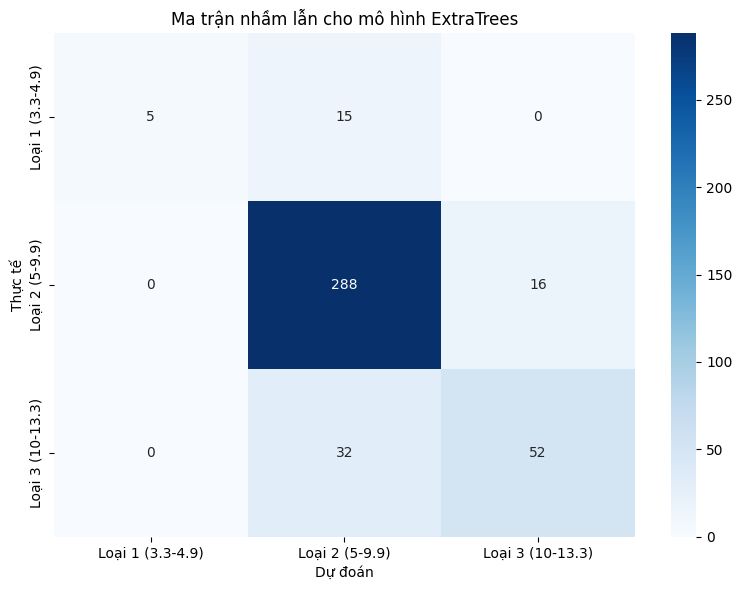

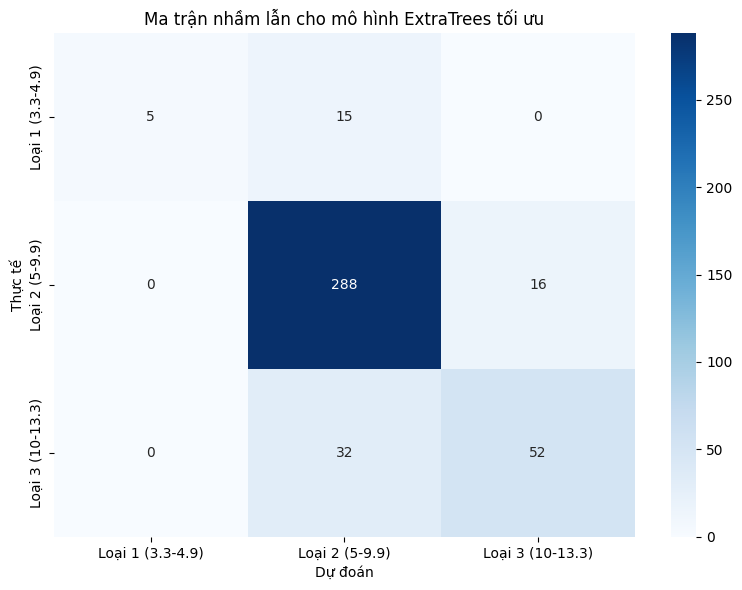

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import GridSearchCV

def build_and_evaluate_extratrees_model(X_train_2d, X_test_2d, y_train, y_test):
    """
    Xây dựng và đánh giá mô hình ExtraTrees cho bài toán phân loại độ ngọt
    """
    # Chuyển đổi nhãn thành 3 loại
    y_train_cat = np.array([categorize_sweetness(y) for y in y_train])
    y_test_cat = np.array([categorize_sweetness(y) for y in y_test])

    # Tạo pipeline với chuẩn hóa dữ liệu và mô hình ExtraTrees
    et_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('extratrees', ExtraTreesClassifier(n_estimators=200, max_depth=30, min_samples_split=2, min_samples_leaf=1, random_state=42))
    ])

    # Đo thời gian huấn luyện
    train_start_time = time.time()
    et_pipeline.fit(X_train_2d, y_train_cat)
    train_time = time.time() - train_start_time

    # Đo thời gian dự đoán
    predict_start_time = time.time()
    y_pred = et_pipeline.predict(X_test_2d)
    predict_time = time.time() - predict_start_time

    # Tính toán các độ đo
    accuracy = accuracy_score(y_test_cat, y_pred)
    precision_macro = precision_score(y_test_cat, y_pred, average='macro')
    precision_weighted = precision_score(y_test_cat, y_pred, average='weighted')
    recall_macro = recall_score(y_test_cat, y_pred, average='macro')
    recall_weighted = recall_score(y_test_cat, y_pred, average='weighted')
    f1_macro = f1_score(y_test_cat, y_pred, average='macro')
    f1_weighted = f1_score(y_test_cat, y_pred, average='weighted')

    # In kết quả
    print("\n=== KẾT QUẢ MÔ HÌNH EXTRATREES ===")
    print(f"Độ chính xác (Accuracy): {accuracy:.4f}")
    print(f"Precision (macro average): {precision_macro:.4f}")
    print(f"Precision (weighted average): {precision_weighted:.4f}")
    print(f"Recall (macro average): {recall_macro:.4f}")
    print(f"Recall (weighted average): {recall_weighted:.4f}")
    print(f"F1 Score (macro average): {f1_macro:.4f}")
    print(f"F1 Score (weighted average): {f1_weighted:.4f}")
    print(f"Thời gian huấn luyện: {train_time:.4f} giây")
    print(f"Thời gian dự đoán: {predict_time:.4f} giây")
    print(f"Tổng thời gian: {train_time + predict_time:.4f} giây")

    # Vẽ ma trận nhầm lẫn
    plt.figure(figsize=(8, 6))
    class_names = ['Loại 1 (3.3-4.9)', 'Loại 2 (5-9.9)', 'Loại 3 (10-13.3)']
    cm = confusion_matrix(y_test_cat, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.title('Ma trận nhầm lẫn cho mô hình ExtraTrees')
    plt.tight_layout()

    return et_pipeline

def optimize_extratrees_model(X_train_2d, X_test_2d, y_train, y_test):
    """
    Sử dụng GridSearchCV để tìm tham số tối ưu cho mô hình ExtraTrees
    """
    # Chuyển đổi nhãn thành 3 loại
    y_train_cat = np.array([categorize_sweetness(y) for y in y_train])
    y_test_cat = np.array([categorize_sweetness(y) for y in y_test])

    # Tạo pipeline với chuẩn hóa dữ liệu và mô hình ExtraTrees
    et_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('extratrees', ExtraTreesClassifier(random_state=42))
    ])

    # Định nghĩa không gian tham số để tìm kiếm
    param_grid = {
        'extratrees__n_estimators': [50, 100, 200],
        'extratrees__max_depth': [30, 50, 70, None],
        'extratrees__min_samples_split': [2, 5, 10],
        'extratrees__min_samples_leaf': [1, 2, 4]
    }

    # Tạo grid search với cross-validation
    print("\n=== BẮT ĐẦU TÌM KIẾM THAM SỐ TỐI ƯU CHO EXTRATREES ===")
    grid_search = GridSearchCV(
        estimator=et_pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    # Huấn luyện grid search
    start_time = time.time()
    grid_search.fit(X_train_2d, y_train_cat)
    total_time = time.time() - start_time
    print(f"\nThời gian tìm kiếm Grid Search: {total_time:.2f} giây")

    # In kết quả
    print(f"\nTham số tốt nhất: {grid_search.best_params_}")
    print(f"Điểm số tốt nhất: {grid_search.best_score_:.4f}")

    # Lấy mô hình tốt nhất từ grid search
    best_model = grid_search.best_estimator_

    # Đánh giá mô hình tốt nhất trên tập test
    y_pred = best_model.predict(X_test_2d)
    accuracy = accuracy_score(y_test_cat, y_pred)
    precision_macro = precision_score(y_test_cat, y_pred, average='macro')
    precision_weighted = precision_score(y_test_cat, y_pred, average='weighted')
    recall_macro = recall_score(y_test_cat, y_pred, average='macro')
    recall_weighted = recall_score(y_test_cat, y_pred, average='weighted')
    f1_macro = f1_score(y_test_cat, y_pred, average='macro')
    f1_weighted = f1_score(y_test_cat, y_pred, average='weighted')

    # In kết quả đánh giá
    print("\n=== KẾT QUẢ MÔ HÌNH EXTRATREES TỐI ƯU ===")
    print(f"Độ chính xác (Accuracy): {accuracy:.4f}")
    print(f"Precision (macro average): {precision_macro:.4f}")
    print(f"Precision (weighted average): {precision_weighted:.4f}")
    print(f"Recall (macro average): {recall_macro:.4f}")
    print(f"Recall (weighted average): {recall_weighted:.4f}")
    print(f"F1 Score (macro average): {f1_macro:.4f}")
    print(f"F1 Score (weighted average): {f1_weighted:.4f}")

    # Vẽ ma trận nhầm lẫn
    plt.figure(figsize=(8, 6))
    class_names = ['Loại 1 (3.3-4.9)', 'Loại 2 (5-9.9)', 'Loại 3 (10-13.3)']
    cm = confusion_matrix(y_test_cat, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.title('Ma trận nhầm lẫn cho mô hình ExtraTrees tối ưu')
    plt.tight_layout()

    return best_model

def compare_models(X_train_2d, X_test_2d, y_train, y_test):
    """
    So sánh các mô hình phân loại
    """
    print("==================================================")
    print("ĐÁNH GIÁ VÀ SO SÁNH CÁC MÔ HÌNH PHÂN LOẠI ĐỘ NGỌT")
    print("==================================================")

    # Đánh giá mô hình ExtraTrees với tham số cơ bản
    print("\nĐang huấn luyện và đánh giá mô hình ExtraTrees cơ bản...")
    extratrees_model = build_and_evaluate_extratrees_model(X_train_2d, X_test_2d, y_train, y_test)

    # Tối ưu hóa mô hình ExtraTrees bằng Grid Search
    print("\nĐang thực hiện tối ưu hóa tham số cho mô hình ExtraTrees...")
    optimized_extratrees_model = optimize_extratrees_model(X_train_2d, X_test_2d, y_train, y_test)

    return extratrees_model, optimized_extratrees_model

# Hàm chính để chạy đánh giá
def main(X_train_2d, X_test_2d, y_train, y_test):
    extratrees_model, optimized_extratrees_model = compare_models(X_train_2d, X_test_2d, y_train, y_test)
    return extratrees_model, optimized_extratrees_model

# Gọi hàm main để chạy phân tích
extratrees_model, optimized_extratrees_model = main(X_train_2d, X_test_2d, y_train, y_test)



**Gradient Boosting**

ĐÁNH GIÁ VÀ SO SÁNH CÁC MÔ HÌNH PHÂN LOẠI ĐỘ NGỌT

Đang huấn luyện và đánh giá mô hình Gradient Boosting...

=== KẾT QUẢ MÔ HÌNH GRADIENT BOOSTING ===
Độ chính xác (Accuracy): 0.8064
Precision (macro average): 0.7214
Precision (weighted average): 0.7973
Thời gian huấn luyện: 413.7925 giây
Thời gian dự đoán: 0.0147 giây
Tổng thời gian: 413.8072 giây


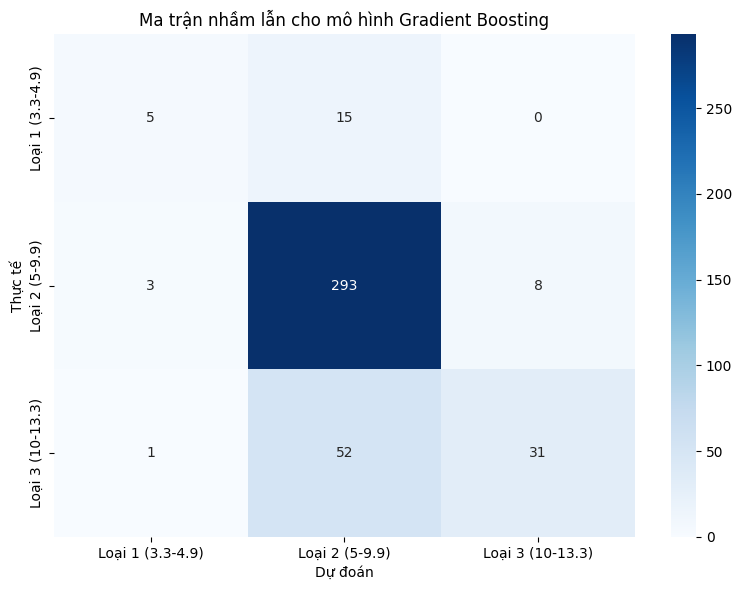

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, confusion_matrix)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time


def build_and_evaluate_gradientboosting_model(X_train_2d, X_test_2d, y_train, y_test):
    """
    Xây dựng và đánh giá mô hình Gradient Boosting cho bài toán phân loại độ ngọt
    """
    # Chuyển đổi nhãn thành 3 loại
    y_train_cat = np.array([categorize_sweetness(y) for y in y_train])
    y_test_cat = np.array([categorize_sweetness(y) for y in y_test])

    # Tạo pipeline với chuẩn hóa dữ liệu và mô hình Gradient Boosting
    gb_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('gradientboosting', GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42))
    ])

    # Đo thời gian huấn luyện
    train_start_time = time.time()
    gb_pipeline.fit(X_train_2d, y_train_cat)
    train_time = time.time() - train_start_time

    # Đo thời gian dự đoán
    predict_start_time = time.time()
    y_pred = gb_pipeline.predict(X_test_2d)
    predict_time = time.time() - predict_start_time

    # Tính toán các độ đo
    accuracy = accuracy_score(y_test_cat, y_pred)
    precision_macro = precision_score(y_test_cat, y_pred, average='macro')
    precision_weighted = precision_score(y_test_cat, y_pred, average='weighted')

    # In kết quả
    print("\n=== KẾT QUẢ MÔ HÌNH GRADIENT BOOSTING ===")
    print(f"Độ chính xác (Accuracy): {accuracy:.4f}")
    print(f"Precision (macro average): {precision_macro:.4f}")
    print(f"Precision (weighted average): {precision_weighted:.4f}")
    print(f"Thời gian huấn luyện: {train_time:.4f} giây")
    print(f"Thời gian dự đoán: {predict_time:.4f} giây")
    print(f"Tổng thời gian: {train_time + predict_time:.4f} giây")

    # Vẽ ma trận nhầm lẫn
    plt.figure(figsize=(8, 6))
    class_names = ['Loại 1 (3.3-4.9)', 'Loại 2 (5-9.9)', 'Loại 3 (10-13.3)']
    cm = confusion_matrix(y_test_cat, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.title('Ma trận nhầm lẫn cho mô hình Gradient Boosting')
    plt.tight_layout()


    return gb_pipeline

def compare_models(X_train_2d, X_test_2d, y_train, y_test):
    """
    So sánh các mô hình phân loại
    """
    print("==================================================")
    print("ĐÁNH GIÁ VÀ SO SÁNH CÁC MÔ HÌNH PHÂN LOẠI ĐỘ NGỌT")
    print("==================================================")

    # Đánh giá mô hình Gradient Boosting
    print("\nĐang huấn luyện và đánh giá mô hình Gradient Boosting...")
    gradientboosting_model = build_and_evaluate_gradientboosting_model(X_train_2d, X_test_2d, y_train, y_test)

    # Nếu bạn muốn giữ AdaBoost trong phần so sánh, giữ dòng này
    # Nếu không, hãy xóa hoặc comment nó
    # adaboost_model = build_and_evaluate_adaboost_model(X_train_2d, X_test_2d, y_train, y_test)

    # Trả về model (hoặc các model nếu muốn so sánh)
    return gradientboosting_model

# Hàm chính để chạy đánh giá
def main(X_train_2d, X_test_2d, y_train, y_test):
    gradientboosting_model = compare_models(X_train_2d, X_test_2d, y_train, y_test)
    return gradientboosting_model


# Chạy mô hình
gradientboosting_model = main(X_train_2d, X_test_2d, y_train, y_test)

**Voting Classifier**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd
import time

In [ ]:
def build_and_evaluate_stacking_classifier(X_train_2d, X_test_2d, y_train, y_test):
    """
    Xây dựng và đánh giá Stacking Classifier cho bài toán phân loại độ ngọt
    sử dụng SVM, ExtraTreesClassifier, LightGBM như base models và
    LogisticRegression làm meta model
    """

    y_train_cat = np.array([categorize_sweetness(y) for y in y_train])
    y_test_cat = np.array([categorize_sweetness(y) for y in y_test])

    # Định nghĩa các base classifiers
    svm = SVC(kernel='rbf', C=140, gamma=0.001, probability=True)
    extra_trees = ExtraTreesClassifier(random_state=42)
    xgb = XGBClassifier(objective='multi:softmax', num_class=3,
                         learning_rate=0.2, n_estimators=200,
                         max_depth=6, random_state=42)

    # Tạo pipeline cho SVM với StandardScaler
    svm_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', svm)
    ])

    # Danh sách base classifiers
    base_classifiers = [
        ('SVM', svm_pipeline),
        ('ExtraTrees', extra_trees),
        ('XGBoost', xgb)
    ]

    # Sử dụng LogisticRegression làm meta model
    meta_model = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial', solver='lbfgs')

    # Xây dựng stacking classifier
    stacking_clf = StackingClassifier(
        estimators=base_classifiers,
        final_estimator=meta_model,
        cv=5,  # Vẫn giữ cv trong quá trình huấn luyện stacking để có được meta-features
        stack_method='predict_proba'
    )

    # Huấn luyện mô hình trên toàn bộ dữ liệu training
    print("Training model on complete training data...")
    stacking_clf.fit(X_train_2d, y_train_cat)

    # Đo thời gian dự đoán
    print("\nMeasuring prediction time...")
    start_time = time.time()
    stacking_predictions = stacking_clf.predict(X_test_2d)
    end_time = time.time()
    prediction_time = end_time - start_time

    # Tính toán các metrics trên tập test
    accuracy = accuracy_score(y_test_cat, stacking_predictions)
    precision = precision_score(y_test_cat, stacking_predictions, average='weighted')
    conf_matrix = confusion_matrix(y_test_cat, stacking_predictions)

    # Hiển thị kết quả
    print("\nTest Set Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Prediction Time: {prediction_time:.4f} seconds")
    print(f"Prediction Speed: {len(X_test_2d)/prediction_time:.2f} samples/second")

    # Vẽ ma trận nhầm lẫn
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['(3,3-4,9)', '(5.0-9.9)', '(10.0-14.3)'],
                yticklabels=['(3,3-4,9)', '(5.0-9.9)', '(10.0-14.3)'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()

    return stacking_clf

# Sử dụng hàm đã tạo
stacking_clf = build_and_evaluate_stacking_classifier(X_train_2d, X_test_2d, y_train, y_test)

Individual Classifier Performance:
SVM: 0.8799
ExtraTreesClassifier: 0.8529
XGB: 0.8309

Performing Grid Search for optimal weights...


**Stacking**

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import time
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


Training model on complete training data...

Measuring prediction time...

Test Set Performance:
Accuracy: 0.8873
Precision: 0.8841
Prediction Time: 0.7223 seconds
Prediction Speed: 564.87 samples/second

Classification Report:
              precision    recall  f1-score   support

   (3,3-4,9)       0.82      0.45      0.58        20
   (5.0-9.9)       0.90      0.95      0.93       304
 (10.0-14.3)       0.83      0.76      0.80        84

    accuracy                           0.89       408
   macro avg       0.85      0.72      0.77       408
weighted avg       0.88      0.89      0.88       408



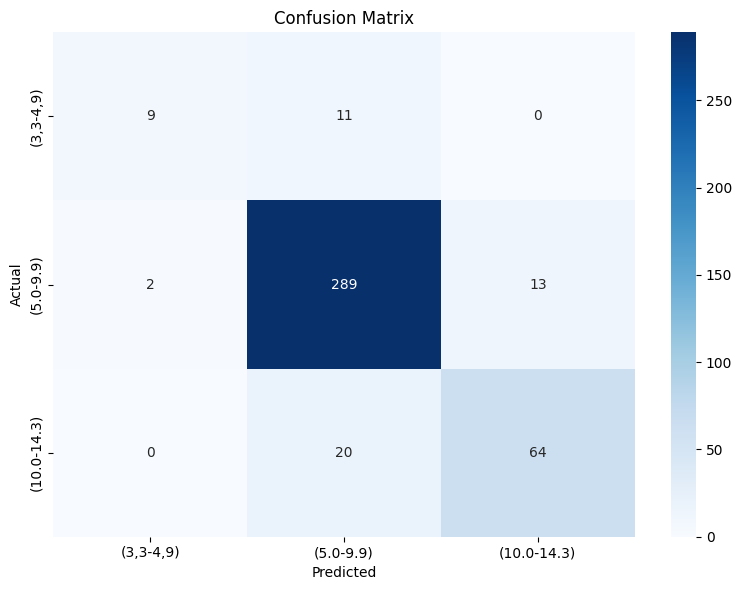

In [ ]:
def build_and_evaluate_stacking_classifier(X_train_2d, X_test_2d, y_train, y_test):
    """
    Xây dựng và đánh giá Stacking Classifier cho bài toán phân loại độ ngọt
    sử dụng SVM, ExtraTreesClassifier, LightGBM như base models và
    LogisticRegression làm meta model
    """

    y_train_cat = np.array([categorize_sweetness(y) for y in y_train])
    y_test_cat = np.array([categorize_sweetness(y) for y in y_test])

    # Định nghĩa các base classifiers
    svm = SVC(kernel='rbf', C=140, gamma=0.001, probability=True)
    extra_trees = ExtraTreesClassifier(n_estimators=200, max_depth=30, min_samples_split=2, min_samples_leaf=1, random_state=42)
    xgb = XGBClassifier(objective='multi:softmax', num_class=3,
                         learning_rate=0.2, n_estimators=200,
                         max_depth=6, random_state=42)
    knn = KNeighborsClassifier()
    nb = GaussianNB()
    ridle = RidgeClassifier()

    # Tạo pipeline cho SVM với StandardScaler
    svm_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', svm)
    ])

    # Danh sách base classifiers
    base_classifiers = [
        ('SVM', svm_pipeline),
        ('ExtraTrees', extra_trees),
        ("KNN", knn),
        ("Naiive Bayes", nb)

    ]


    meta_model = ridle
    # Xây dựng stacking classifier
    stacking_clf = StackingClassifier(
        estimators=base_classifiers,
        final_estimator=meta_model,
        cv=3,  # Vẫn giữ cv trong quá trình huấn luyện stacking để có được meta-features
        stack_method='predict_proba',
        passthrough=True  # Thêm dữ liệu gốc vào đầu vào cho meta
    )

    # Huấn luyện mô hình trên toàn bộ dữ liệu training
    print("Training model on complete training data...")
    stacking_clf.fit(X_train_2d, y_train_cat)

    # Đo thời gian dự đoán
    print("\nMeasuring prediction time...")
    start_time = time.time()
    stacking_predictions = stacking_clf.predict(X_test_2d)
    end_time = time.time()
    prediction_time = end_time - start_time

    # Tính toán các metrics trên tập test
    accuracy = accuracy_score(y_test_cat, stacking_predictions)
    precision = precision_score(y_test_cat, stacking_predictions, average='weighted')
    conf_matrix = confusion_matrix(y_test_cat, stacking_predictions)

    # Hiển thị kết quả
    print("\nTest Set Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Prediction Time: {prediction_time:.4f} seconds")
    print(f"Prediction Speed: {len(X_test_2d)/prediction_time:.2f} samples/second")

    # Vẽ ma trận nhầm lẫn
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['(3,3-4,9)', '(5.0-9.9)', '(10.0-14.3)'],
                yticklabels=['(3,3-4,9)', '(5.0-9.9)', '(10.0-14.3)'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    class_report = classification_report(y_test_cat, stacking_predictions,
                                         target_names=['(3,3-4,9)', '(5.0-9.9)', '(10.0-14.3)'])
    print("\nClassification Report:")
    print(class_report)
    return stacking_clf

# Sử dụng hàm đã tạo
stacking_clf = build_and_evaluate_stacking_classifier(X_train_2d, X_test_2d, y_train, y_test)